# Toy Model Implementation

In [ ]:
import os

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import pearsonr, ttest_1samp, false_discovery_control
import torch
from sklearn.metrics import roc_curve, auc

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/pkn_signaling.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
# VESPA
'''x_data = pd.read_csv(os.path.join('data', 'vespa_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'vespa_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'vespa_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'vespa_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'vespa_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# DECRYPTM
'''x_data = pd.read_csv(os.path.join('data', 'decryptm_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'decryptm_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'decryptm_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'decryptm_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'decryptm_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF
'''x_data = pd.read_csv(os.path.join('data', 'egf_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF global
'''x_data = pd.read_csv(os.path.join('data', 'egf_x_global.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell_global.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug_global.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y_global.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map_global.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF combined (EGF + Inhibitors)
x_data = pd.read_csv(os.path.join('data', 'egf_x_all.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell_all.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug_all.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y_all.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map_all.csv'), sep=',', low_memory=False, index_col=0)

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())
display(nodes_sites_map.head())

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


,R1,R2
Drug_CL,,
DMSO_R1,1.0,0.0
DMSO_R2,0.0,1.0
EGF_R1,1.0,0.0
EGF_R2,0.0,1.0
LY294002-EGF_R1,1.0,0.0


,DMSO,EGF,LY294002,SHP099,SL0101,UO126
O00329,0,0,1,0,0,0
P01133,0,1,0,0,0,0
P36507,0,0,0,0,0,1
P42336,0,0,1,0,0,0
P42338,0,0,1,0,0,0


,1433E:P62258:S210s,1433E:P62258:S233s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S45s,1433S:P31947:S63s,1433S:P31947:S64s,1433S:P31947:S69s,1433S:P31947:S74s,1433S:P31947:T90t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433G:P61981:S71s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S209s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S45s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Scaling down the problem to KEGG or SIGNOR
database = "KEGG"
net= net[net['sources'].str.contains(database, na=False)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map.loc[:, nodes_sites_map.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

nodes_sites_map_sub = nodes_sites_map

display(nodes_sites_map_sub.head())
display(y_data.head())

,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433G:P61981:S71s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S209s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S45s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433E:P62258:S210s,1433E:P62258:S233s,1433T:P27348:S232s,1A03:P04439:S343s,1A03:P04439:S350s,1A03:P04439:S352s,1A03:P04439:S356s,1A03:P04439:S359s,1C07:P10321:S353s,1C07:P10321:S357s,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


In [5]:
'''row_filter = "R2"
x_data = x_data[x_data.index.str.contains(row_filter)]
x_cell = x_cell[x_cell.index.str.contains(row_filter)]
y_data = y_data[y_data.index.str.contains(row_filter)]
'''

'''pattern = r'_(5760|1440|2880)$'
y_data = y_data[~y_data.index.str.contains(pattern)]'''

'''cell_filter = 'SU-DHL-4'
drug_filter = 'Rituximab'
x_data = x_data[x_data.index.str.contains(drug_filter)]
#x_data = x_data[x_data.index.str.contains(cell_filter)]
x_data = x_data.loc[:, x_data.columns.str.contains(drug_filter)]
x_cell = x_cell[x_cell.index.str.contains(drug_filter)]
#x_cell = x_data[x_data.index.str.contains(cell_filter)]
x_drug = x_drug.loc[:, x_drug.columns.str.contains(drug_filter)]
x_drug = x_drug.loc[~(x_drug == 0).all(axis=1)]
y_data = y_data[y_data.index.str.contains(drug_filter)]
#y_data = y_data[y_data.index.str.contains(cell_filter)]
#pattern = r'_(360|1440)$'
#y_data = y_data[~y_data.index.str.contains(pattern)]
y_data = y_data.mask(y_data > 30, np.nan)  # Masking outliers'''

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


,R1,R2
Drug_CL,,
DMSO_R1,1.0,0.0
DMSO_R2,0.0,1.0
EGF_R1,1.0,0.0
EGF_R2,0.0,1.0
LY294002-EGF_R1,1.0,0.0


,DMSO,EGF,LY294002,SHP099,SL0101,UO126
O00329,0,0,1,0,0,0
P01133,0,1,0,0,0,0
P36507,0,0,0,0,0,1
P42336,0,0,1,0,0,0
P42338,0,0,1,0,0,0


,1433E:P62258:S210s,1433E:P62258:S233s,1433T:P27348:S232s,1A03:P04439:S343s,1A03:P04439:S350s,1A03:P04439:S352s,1A03:P04439:S356s,1A03:P04439:S359s,1C07:P10321:S353s,1C07:P10321:S357s,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


In [6]:
# Filter nodes based on the networks input
G = nx.from_pandas_edgelist(net, source='source', target='target', create_using=nx.DiGraph())

start_nodes = list(x_drug.index)
print("Starting nodes:", start_nodes)

# Compute the reachable nodes from all start nodes.
reachable_nodes = set()
for node in start_nodes:
    if node in G:  # Only consider nodes present in the graph
        reachable_nodes.update(nx.descendants(G, node))
        reachable_nodes.add(node)
    else:
        print(f"Warning: Starting node {node} not found in graph.")

reachable_list = sorted(reachable_nodes)
print("Number of nodes connected to 'P01133':")
print(len(reachable_list))

# Filter dataframes
net = net[net['source'].isin(reachable_list) & net['target'].isin(reachable_list)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map_sub.loc[:, nodes_sites_map_sub.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

display(nodes_sites_map_sub.head())
display(y_data.head())

# Plot the graph
'''plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_nodes(G, pos,
                       nodelist=list(reachable_nodes),
                       node_color="red", node_size=500)
plt.title("Graph - Nodes reachable from 'P01133' (in red)")
plt.axis("off")
plt.show()'''

Starting nodes: ['O00329', 'P01133', 'P36507', 'P42336', 'P42338', 'Q02750', 'Q06124', 'Q15418']
Number of nodes connected to 'P01133':
523


,O00141,O00273,O00329,O00401,O00418,O14492,O14733,O14745,O14920,O14950,...,Q9Y281,Q9Y2D8,Q9Y2Z0,Q9Y490,Q9Y4H2,Q9Y5V3,Q9Y624,Q9Y6K9,Q9Y6N7,Q9Y6W5
1433T:P27348:S232s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S278s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S416s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S444s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4EBP1:Q13541:S101s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433T:P27348:S232s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,4EBP1:Q13541:S65s,4EBP1:Q13541:S83s,4EBP1:Q13541:S86s,4EBP1:Q13541:T36t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


'plt.figure(figsize=(12, 12))\npos = nx.spring_layout(G)\n\nnx.draw_networkx_edges(G, pos, alpha=0.5)\nnx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)\nnx.draw_networkx_labels(G, pos, font_size=8)\n\nnx.draw_networkx_nodes(G, pos,\n                       nodelist=list(reachable_nodes),\n                       node_color="red", node_size=500)\nplt.title("Graph - Nodes reachable from \'P01133\' (in red)")\nplt.axis("off")\nplt.show()'

In [7]:
display(net.head())

,source,target,direction,stimulation,inhibition,sources,references,0
3,P17612,Q8NER1,1,1,0,HPRD_MIMP;KEGG;MIMP;PhosphoSite_MIMP;PhosphoSi...,TRIP:12194871,NaN
4,P12931,Q8NER1,1,1,0,KEGG;MIMP;NCI-PID_ProtMapper;PhosphoSite;Phosp...,PhosphoSite:16319926;ProtMapper:16319926;ProtM...,NaN
13,Q16539,P49137,1,1,0,ACSN;BEL-Large-Corpus_ProtMapper;BioGRID;CA1;C...,ACSN:11274345;ACSN:12738796;ACSN:15187187;ACSN...,NaN
16,O60674,P19235,1,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,NaN
17,P19235,O60674,1,0,0,BioGRID;Cui2007;HPRD;KEGG-MEDICUS;SignaLink3;Wang,BioGRID:8343951;HPRD:11779507;HPRD:12441334;HP...,NaN


Let's see what the signaling network looks like:

In [8]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
3,P17612,Q8NER1,1,0
4,P12931,Q8NER1,1,0
13,Q16539,P49137,1,0
16,O60674,P19235,1,0
17,P19235,O60674,0,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [9]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
3,P17612,Q8NER1,1.0,1,0
4,P12931,Q8NER1,1.0,1,0
13,Q16539,P49137,1.0,1,0
16,O60674,P19235,1.0,1,0
17,P19235,O60674,0.1,0,0


## Define Parameters to Build and Train Model

In [10]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 3000, 
             'learning_rate': 2e-3,
             'variable_lr': True}
other_params = {'lambda_dynamic': 1, 'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-2}  # 1e-7 if not using variable gradient noise
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5, 'lambda_simplify': 0}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
module_params = {
    'use_cln': True,
    'cln_hidden_layers': {1: 64, 2: 16},  # {1: 64, 2: 16}
    'use_xssn': True,
    'xssn_hidden_layers': None,
    'use_time': True,
    'n_timepoints': 5,
    'use_phospho': True,
    'nsl_hidden_layers': {1: 16, 2:8}, #{1: 16},
    'conn_dim': 5 #5
}

hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params, **module_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [11]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map_sub,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     activation_function = 'MML',  # leaky_relu
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [12]:
mod.X_in.head()

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


In [13]:
mod.y_out.head()

,1433T:P27348:S232s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,4EBP1:Q13541:S65s,4EBP1:Q13541:S83s,4EBP1:Q13541:S86s,4EBP1:Q13541:T36t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


Fold 1: Test candidate drug = LY294002
i=0, l=0.44878, s=0.703, r=0.00020, v=0, Time-mapping index: [0, 26, 46, 62, 75]
i=250, l=0.17303, s=0.533, r=0.00046, v=0, Time-mapping index: [0, 26, 46, 62, 74]
i=500, l=0.07619, s=0.650, r=0.00110, v=0, Time-mapping index: [0, 25, 45, 62, 74]
i=750, l=0.06731, s=0.679, r=0.00174, v=0, Time-mapping index: [0, 11, 32, 48, 62]
i=1000, l=0.06465, s=0.666, r=0.00200, v=0, Time-mapping index: [0, 10, 37, 53, 66]
i=1250, l=0.05237, s=0.637, r=0.00191, v=0, Time-mapping index: [0, 11, 37, 53, 66]
i=1500, l=0.05403, s=0.660, r=0.00166, v=1, Time-mapping index: [0, 10, 37, 53, 66]
i=1750, l=0.05164, s=0.721, r=0.00129, v=0, Time-mapping index: [0, 10, 36, 52, 65]
i=2000, l=0.05061, s=0.701, r=0.00087, v=0, Time-mapping index: [0, 10, 36, 52, 65]
i=2250, l=0.04568, s=0.766, r=0.00048, v=1, Time-mapping index: [0, 11, 36, 52, 65]
i=2500, l=0.05079, s=0.769, r=0.00017, v=0, Time-mapping index: [0, 11, 36, 52, 65]
i=2750, l=0.04603, s=0.731, r=0.00002, v=0,

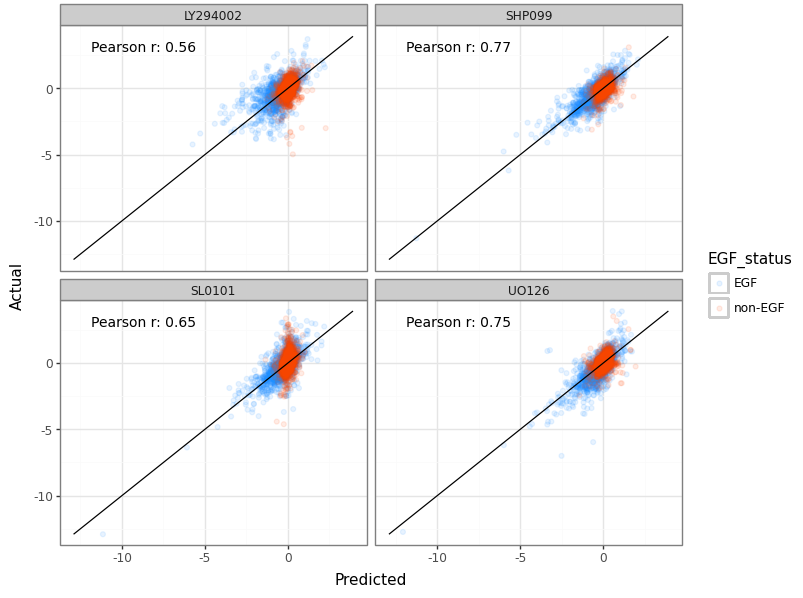

In [14]:
indices = y_data.index
drug_names = indices.to_series().apply(lambda s: s.split('_')[0])

# Define constant training drugs: do NOT contain "EGF" AND "EGF" AND "DMSO"
controls = []
cand_EGF = []       # drugs that contain "EGF" but are not controls
cand_nonEGF = []    # drugs that do NOT contain "EGF"
for drug in drug_names.unique():
    if drug in ["EGF", "DMSO"]:
        controls.append(drug)
    elif "EGF" in drug:
        cand_EGF.append(drug)
    else:
        cand_nonEGF.append(drug)


# Sort test candidates for deterministic behavior
cand_EGF = sorted(cand_EGF)
cand_nonEGF = sorted(cand_nonEGF)

n_folds = 4
# For each fold, select one candidate from each candidate list
fold_candidate_EGF = [cand_EGF[i % len(cand_EGF)] for i in range(n_folds)]
fold_candidate_nonEGF = [cand_nonEGF[i % len(cand_nonEGF)] for i in range(n_folds)]

# Build folds: Test set will contain rows with the selected EGF drug OR the selected non‑EGF drug.
folds = []
for i in range(n_folds):
    selected_EGF = fold_candidate_EGF[i]
    selected_nonEGF = fold_candidate_nonEGF[i]
    # Test indices: rows with either candidate.
    test_idx = indices[(drug_names == selected_EGF) | (drug_names == selected_nonEGF)]
    test_idx = test_idx[test_idx.str.endswith('_12')]  # remove time point 0 from the evaluation
    # Training indices: all other rows.
    train_idx = indices[(drug_names != selected_EGF) & (drug_names != selected_nonEGF)]
    folds.append((train_idx, test_idx))

# Now, for each fold you can do the following:
fold_results = []
test_dfs = []

for i, (train_idx, test_idx) in enumerate(folds, start=1):
    print(f"Fold {i}: Test candidate drug = {fold_candidate_nonEGF[i-1]}")
    
    train_drugs = train_idx.to_series().apply(lambda s: s.rsplit('_', 1)[0]).unique()
    test_drugs  = test_idx.to_series().apply(lambda s: s.rsplit('_', 1)[0]).unique()
    
    # Subset data according to your indices; here assuming x_data, x_cell, and y_data have matching indices.
    x_train = x_data.loc[train_drugs]
    x_train_cell = x_cell.loc[train_drugs]
    y_train = y_data.loc[train_idx]
    
    x_test = x_data.loc[test_drugs]
    x_test_cell = x_cell.loc[test_drugs]
    y_test = y_data.loc[test_idx]
    
    # Extract the EGF control for time point 12
    EGF_R1_12_idx = next(i for i, idx in enumerate(y_train.index) if idx == 'EGF_R1_12')
    EGF_R2_12_idx = next(i for i, idx in enumerate(y_train.index) if idx == 'EGF_R2_12')
    DMSO_R1_12_idx = next(i for i, idx in enumerate(y_train.index) if idx == 'DMSO_R1_12')
    DMSO_R2_12_idx = next(i for i, idx in enumerate(y_train.index) if idx == 'DMSO_R2_12')

    # Define controls for Benchmarking
    control1 = mod.df_to_tensor(y_train.iloc[[EGF_R1_12_idx]])  # EGF_R1_12
    control2 = mod.df_to_tensor(y_train.iloc[[EGF_R2_12_idx]])  # EGF_R2_12
    control3 = mod.df_to_tensor(y_train.iloc[[DMSO_R1_12_idx]])  # DMSO_R1_12
    control4 = mod.df_to_tensor(y_train.iloc[[DMSO_R2_12_idx]])  # DMSO_R2_12
    
    EGF_control = torch.cat([
        mod.df_to_tensor(y_train.iloc[[EGF_R1_12_idx]]),
        mod.df_to_tensor(y_train.iloc[[EGF_R2_12_idx]]),
        mod.df_to_tensor(y_train.iloc[[DMSO_R1_12_idx]]),
        mod.df_to_tensor(y_train.iloc[[DMSO_R2_12_idx]])
    ], dim=0)
    
    mod = SignalingModel(net = net,
                     X_in = x_train,
                     y_out = y_train, 
                     X_cell = x_train_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map_sub,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     activation_function = 'MML',  # leaky_relu
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)
    
    # --- Model setup & training using only the training part of the fold ---
    mod.input_layer.weights.requires_grad = False  # do not update ligand scaling factors
    mod.signaling_network.prescale_weights(target_radius=target_spectral_radius)
    
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam  # pass model parameters within train_signaling_model if needed
    
    # Train the model
    (mod_trained, cur_loss, cur_eig, mean_loss, stats, 
     X_train_new, X_test_new, X_train_index, y_train_new, y_test_new, y_train_index, 
     X_cell_train_new, X_cell_test_new, missing_node_indexes, floor_idx, ceil_idx, weight) = train_signaling_model(
            mod, net, optimizer, loss_fn,
            reset_epoch=200,
            hyper_params=hyper_params,
            train_split_frac={'train': 1, 'test': 0},
            train_seed=seed,
            verbose=True,
            split_by='condition',
            unique_time_points = [12],
            noise_scale=0.0)

    # --- Evaluation on the test split for this fold ---
    Y_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod_trained(
        mod.df_to_tensor(x_test), mod.df_to_tensor(x_test_cell), missing_node_indexes)
    
    # For instance, if you use fixed unique time points:
    unique_time_points = [12]
    Y_subsampled = Y_fullFull_test[:, unique_time_points, :]
    
    # Subtract EGF control to get relative changes for benchmarking
    Y_sub_corrected = Y_subsampled.clone()
    Y_sub_corrected[0, 0, :] = Y_sub_corrected[0, 0, :] - control1.squeeze(0)
    Y_sub_corrected[1, 0, :] = Y_sub_corrected[1, 0, :] - control2.squeeze(0)
    Y_sub_corrected[2, 0, :] = Y_sub_corrected[2, 0, :] - control3.squeeze(0)
    Y_sub_corrected[3, 0, :] = Y_sub_corrected[3, 0, :] - control4.squeeze(0)
    
    # Subtract the first time point from predicted data
    #Y_sub_corrected = Y_sub_corrected - Y_sub_corrected[:, 0:1, :]
    Y_sub_corrected = Y_sub_corrected.permute(1, 0, 2)
    Y_sub_corrected = torch.flatten(Y_sub_corrected, start_dim=0, end_dim=1)
    
    # Similarly process y_test
    y_test_tensor = mod.df_to_tensor(y_test)
    
    # Subtract EGF control to get relative changes for benchmarking
    y_test_corrected = y_test_tensor.clone()
    y_test_corrected[0, :] = y_test_corrected[0, :] - control1.squeeze(0)
    y_test_corrected[1, :] = y_test_corrected[1, :] - control2.squeeze(0)
    y_test_corrected[2, :] = y_test_corrected[2, :] - control3.squeeze(0)
    y_test_corrected[3, :] = y_test_corrected[3, :] - control4.squeeze(0)
    
    y_test_corrected = y_test_corrected.reshape(1, -1, mod.y_out.shape[1])
    #y_test_corrected = y_test_corrected - y_test_corrected[0:1, :, :]
    y_test_corrected = torch.flatten(y_test_corrected, start_dim=0, end_dim=1)
    
    # Convert to numpy and compute Pearson r
    EGF_control_np = EGF_control.detach().flatten().cpu().numpy()
    y_pred_np = Y_sub_corrected.detach().flatten().cpu().numpy()
    y_actual_np = y_test_corrected.detach().flatten().cpu().numpy()
    mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np) & ~np.isnan(EGF_control_np)
    y_pred_filtered = y_pred_np[mask]
    y_actual_filtered = y_actual_np[mask]
    EGF_control_filtered = EGF_control_np[mask]
    pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)
    
    print(f"Fold {i} Pearson r: {pr:.2f}")
    
    # Save fold result as needed
    fold_results.append({'fold': i, 'candidate_drug': fold_candidate_nonEGF[i-1],
                         'pearson': pr, 'stats': stats})
    
    # Save the test prediction scatter for plotting:
    drug_index = y_test.index.to_series().apply(lambda s: s.rsplit('_', 1)[0])
    n_genes = mod.y_out.shape[1]
    drug_labels = np.repeat(drug_index.values, n_genes)  # genes x number of samples
    drug_labels = drug_labels[mask]
    
    df_fold = pd.DataFrame({
        'Predicted': y_pred_filtered,
        'Actual': y_actual_filtered,
        'EGF_control': EGF_control_filtered,
        'Drug': drug_labels,
        'Phosphosites': np.tile(mod.y_out.columns, len(y_pred_np) // len(mod.y_out.columns))[mask]
    })
    df_fold['EGF_status'] = df_fold['Drug'].apply(lambda d: 'EGF' if 'EGF' in d else 'non-EGF')
    df_fold['CV_set'] = fold_candidate_nonEGF[i-1]  # label facet with candidate drug name
    test_dfs.append(df_fold)


# Combine results for plotting
viz_df_cv = pd.concat(test_dfs, axis=0)
global_min = min(viz_df_cv['Predicted'].min(), viz_df_cv['Actual'].min())
global_max = max(viz_df_cv['Predicted'].max(), viz_df_cv['Actual'].max())
line_df = pd.DataFrame({'x': [global_min, global_max], 'y': [global_min, global_max]})

# Build a DataFrame for the Pearson annotation for each fold.
pearson_list = []
for res in fold_results:
    pearson_list.append({
        'CV_set': res['candidate_drug'],
        'label': f"Pearson r: {res['pearson']:.2f}",
        'x': global_min + 0.25*(global_max - global_min),
        'y': global_max - 0.05*(global_max - global_min)
    })
pearson_df = pd.DataFrame(pearson_list)

# Plot test correlation scatter faceted by CV_set (candidate drug)
width, height = 8, 6
p_cv = (
    p9.ggplot(viz_df_cv) +
    p9.geom_point(mapping=p9.aes(x='Predicted', y='Actual', color='EGF_status'), alpha=0.1) +
    p9.facet_wrap('~ CV_set') +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() +
    p9.theme(figure_size=(width, height)) +
    p9.geom_text(data=pearson_df, mapping=p9.aes(x='x', y='y', label='label'), size=10) +
    p9.scale_color_manual(values={'EGF': '#1E90FF', 'non-EGF': '#FF4500'})
)
p_cv.draw()

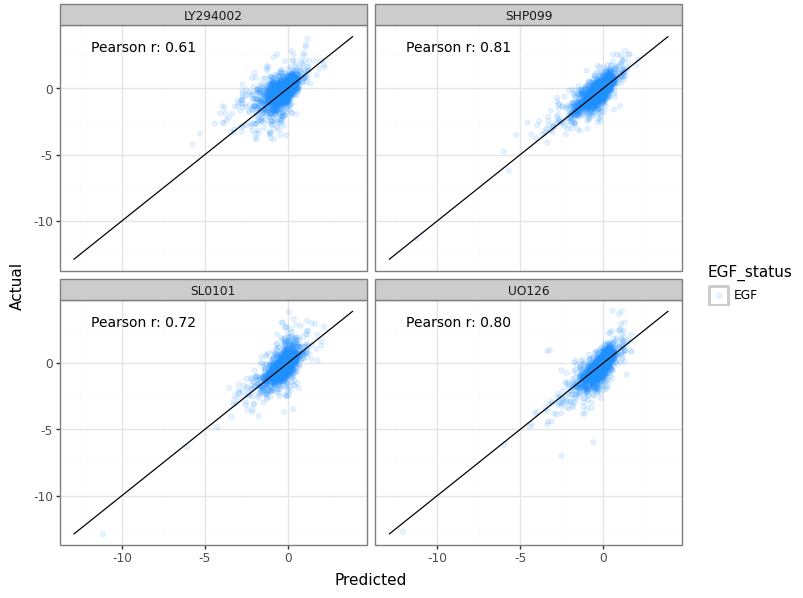

In [15]:
viz_df_cv_sub = viz_df_cv[viz_df_cv['Drug'].str.contains("EGF")]
global_min = min(viz_df_cv_sub['Predicted'].min(), viz_df_cv_sub['Actual'].min())
global_max = max(viz_df_cv_sub['Predicted'].max(), viz_df_cv_sub['Actual'].max())
line_df = pd.DataFrame({'x': [global_min, global_max], 'y': [global_min, global_max]})

# Recalculate Pearson correlations for each drug after filtering to EGF samples
pearson_list = []
for cv_set in viz_df_cv_sub['CV_set'].unique():
    # Filter data for this CV set
    df_subset = viz_df_cv_sub[viz_df_cv_sub['CV_set'] == cv_set]
    
    # Calculate Pearson correlation for this subset
    mask = ~np.isnan(df_subset['Predicted']) & ~np.isnan(df_subset['Actual'])
    pred_filtered = df_subset['Predicted'][mask]
    actual_filtered = df_subset['Actual'][mask]
    
    if len(pred_filtered) > 1:  # Ensure we have enough data points
        pr, _ = pearsonr(pred_filtered, actual_filtered)
        
        pearson_list.append({
            'CV_set': cv_set,
            'label': f"Pearson r: {pr:.2f}",
            'x': global_min + 0.25*(global_max - global_min),
            'y': global_max - 0.05*(global_max - global_min)
        })
        
pearson_df = pd.DataFrame(pearson_list)

# Plot test correlation scatter faceted by CV_set (candidate drug)
width, height = 8, 6
p_cv = (
    p9.ggplot(viz_df_cv_sub) +
    p9.geom_point(mapping=p9.aes(x='Predicted', y='Actual', color='EGF_status'), alpha=0.1) +
    p9.facet_wrap('~ CV_set') +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() +
    p9.theme(figure_size=(width, height)) +
    p9.geom_text(data=pearson_df, mapping=p9.aes(x='x', y='y', label='label'), size=10) +
    p9.scale_color_manual(values={'EGF': '#1E90FF', 'non-EGF': '#FF4500'})
)
p_cv.draw()

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning

,drug,Upregulated Sites,Downregulated Sites,Total Sites,Up AUC,Down AUC
0,LY294002,11,57,1160,0.795553,0.816195
1,SHP099,13,68,1378,0.928656,0.909026
2,SL0101,23,60,1173,0.837278,0.873795
3,UO126,18,91,1378,0.963358,0.888240


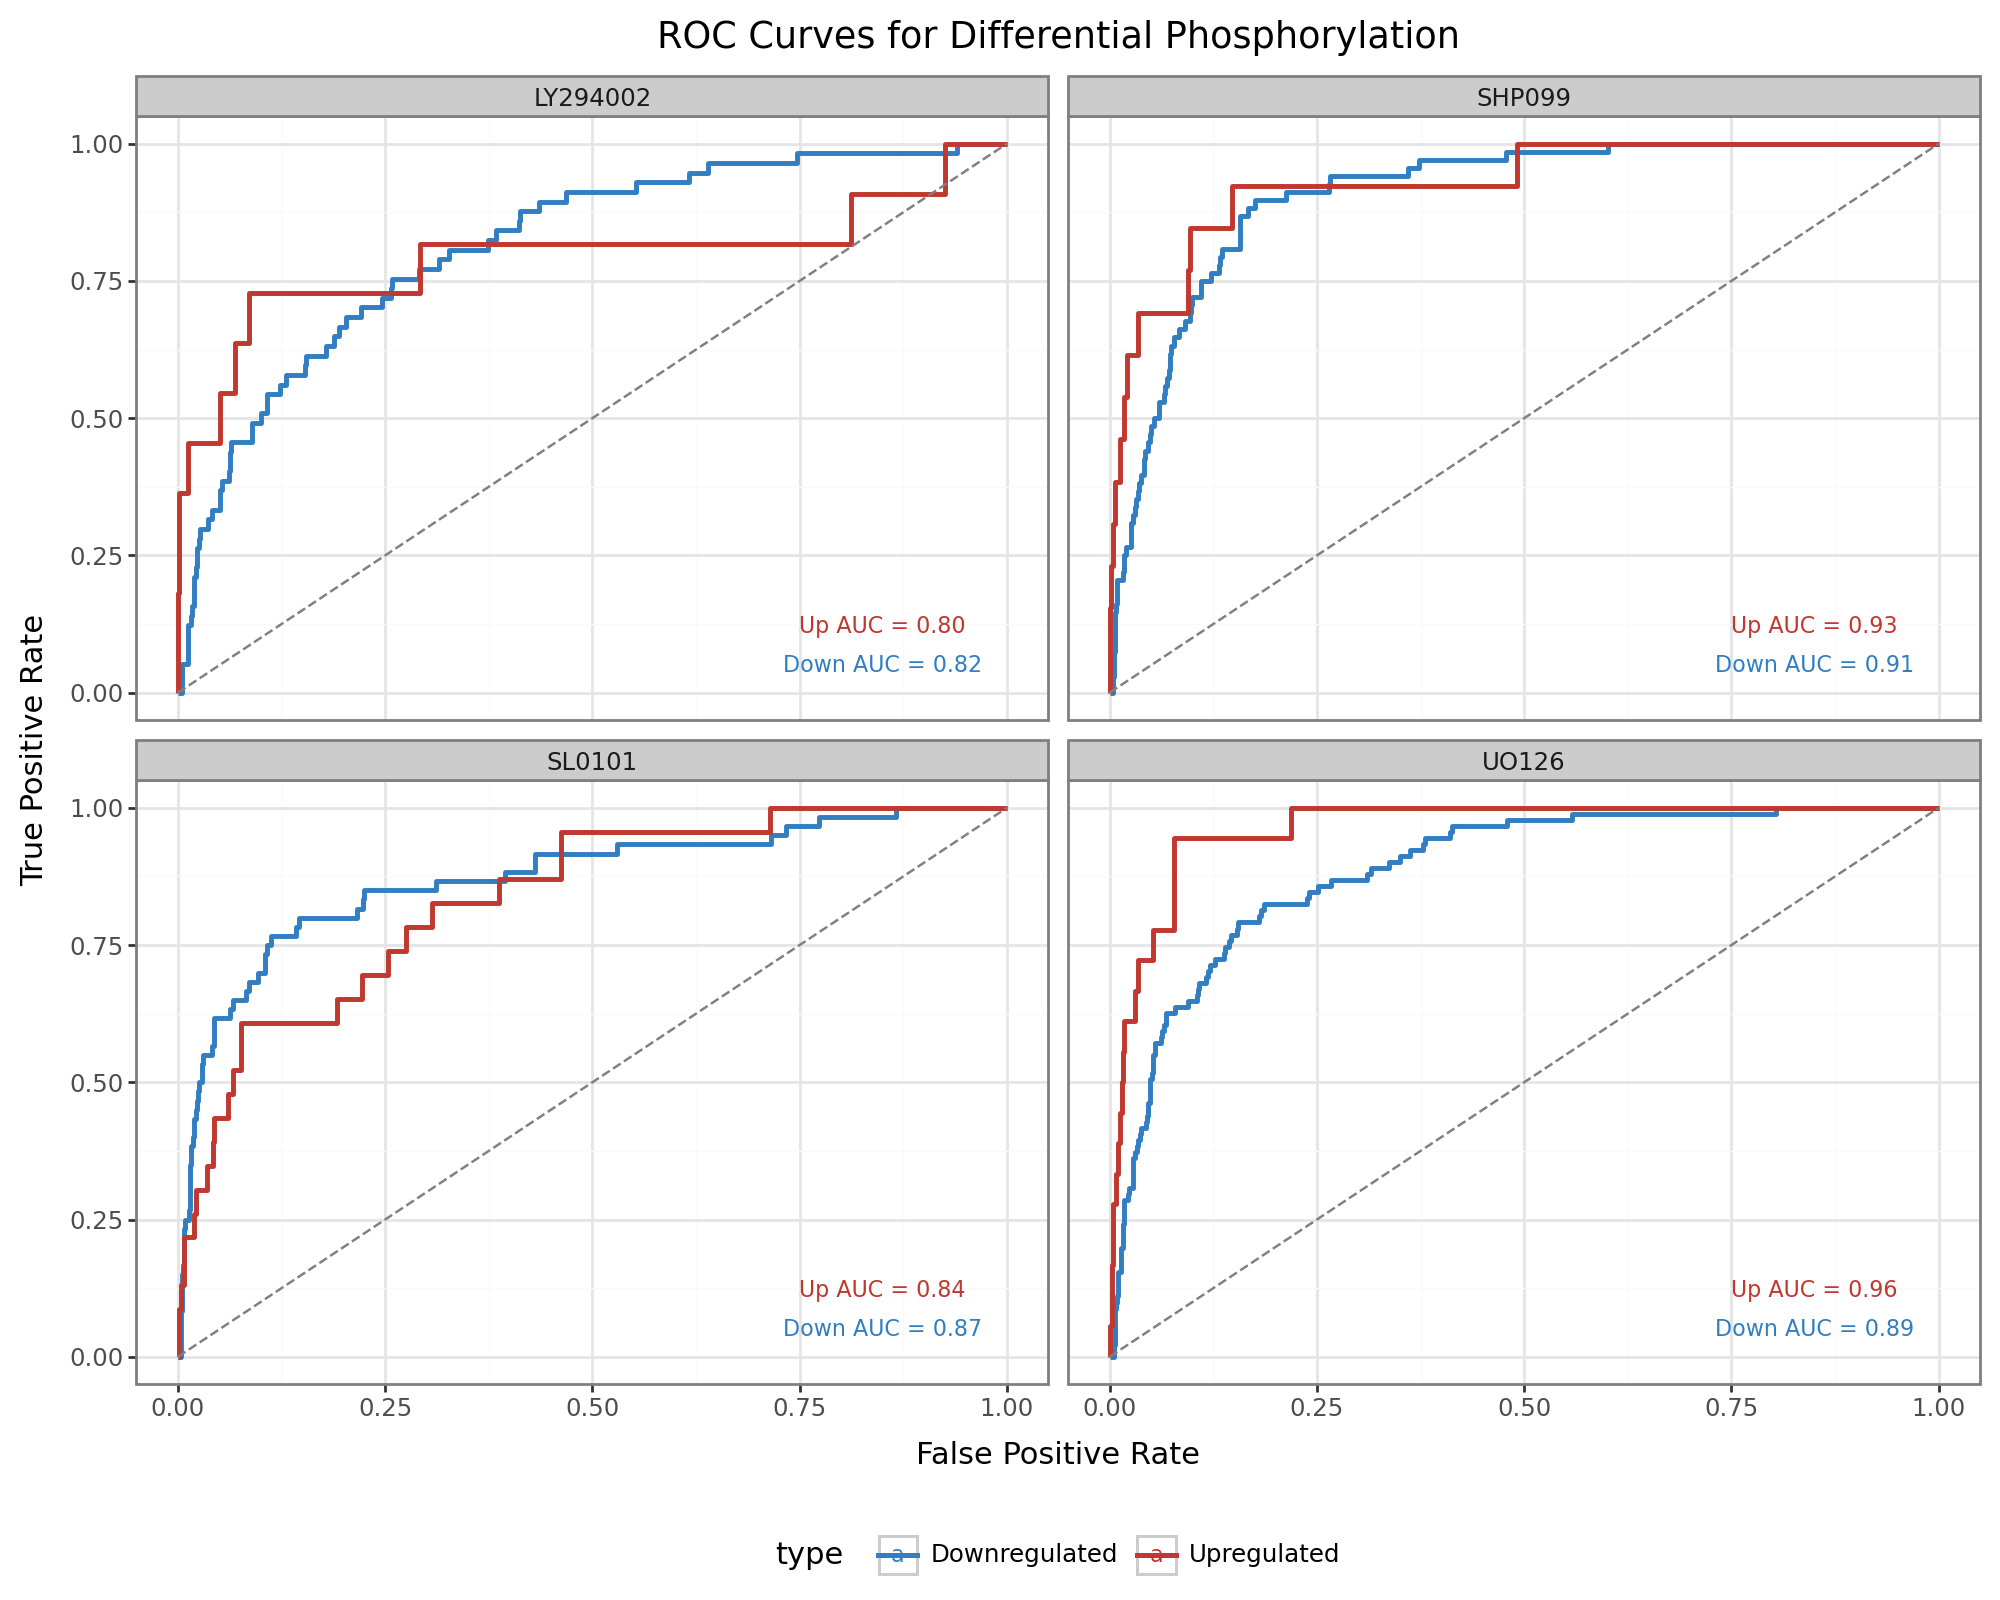

In [ ]:
'''def run_dea_and_roc_all_drugs(viz_df_cv, value_column="Predicted", reference_column="Actual", alpha=0.05):
    """
    Run differential expression and ROC analysis for all drugs in CV sets.
    """
    results = {}
    all_roc_dfs = []
    
    # Get unique drugs to analyze
    unique_drugs = [drug for drug in viz_df_cv['CV_set'].unique() if drug != "DMSO"]
    
    for drug_name in unique_drugs:
        # Filter for this drug
        subset = viz_df_cv[(viz_df_cv['Drug'].str.contains(f"{drug_name}-EGF"))]
        
        if len(subset) < 10 or subset['Drug'].nunique() < 2:
            print(f"Not enough data for DEA on {drug_name}.")
            continue
            
        # Pivot to get replicates as columns (each row is a phosphosite)
        pivot_pred = subset.pivot(index='Phosphosites', columns='Drug', values=value_column)
        pivot_act = subset.pivot(index='Phosphosites', columns='Drug', values=reference_column)

        # Run one-sample t-test against 0 for each phosphosite (on Actual values)
        t_stat, p_vals = ttest_1samp(pivot_act.values, popmean=0, axis=1, nan_policy='omit')
        # Handle any NaNs in p-values
        valid_mask = ~np.isnan(p_vals)
        p_vals_clean = np.copy(p_vals)
        p_vals_clean[~valid_mask] = 1.0  # Set NaN values to 1.0 for FDR calculation
        
        # Apply FDR correction
        adj_p_vals = false_discovery_control(p_vals_clean, method='bh')
        
        # Restore NaN values in the adjusted p-values
        adj_p_vals[~valid_mask] = np.nan
        means = np.nanmean(pivot_act.values, axis=1)
        
        # Define binary labels
        is_up = (p_vals < alpha) & (means > 1) 
        is_down = (p_vals < alpha) & (means < -1)
        
        pred_scores = np.nanmean(pivot_pred.values, axis=1)

        # ROC for upregulated
        fpr_up, tpr_up, _ = roc_curve(is_up.astype(int), pred_scores)
        auc_up = auc(fpr_up, tpr_up)
        
        # ROC for downregulated
        fpr_down, tpr_down, _ = roc_curve(is_down.astype(int), -pred_scores)  # Use negative scores for downreg
        auc_down = auc(fpr_down, tpr_down)

        # Save ROC curve data for plotting
        roc_up_df = pd.DataFrame({'fpr': fpr_up, 'tpr': tpr_up, 'type': 'Upregulated', 'drug': drug_name})
        roc_down_df = pd.DataFrame({'fpr': fpr_down, 'tpr': tpr_down, 'type': 'Downregulated', 'drug': drug_name})
        all_roc_dfs.append(pd.concat([roc_up_df, roc_down_df]))
        
        # Store results
        results[drug_name] = {
            'fpr_up': fpr_up, 'tpr_up': tpr_up, 'auc_up': auc_up,
            'fpr_down': fpr_down, 'tpr_down': tpr_down, 'auc_down': auc_down,
            'true_up': sum(is_up), 'true_down': sum(is_down), 
            'total_sites': len(is_up), 'drug': drug_name
        }
    
    if all_roc_dfs:
        all_roc_df = pd.concat(all_roc_dfs)
        
        diag_df = pd.DataFrame({'x': [0, 1], 'y': [0, 1]})
        
        auc_annotations = []
        for drug in results:
            auc_annotations.extend([
                {'x': 0.85, 'y': 0.12, 'label': f'Up AUC = {results[drug]["auc_up"]:.2f}', 
                 'type': 'Upregulated', 'drug': drug},
                {'x': 0.85, 'y': 0.05, 'label': f'Down AUC = {results[drug]["auc_down"]:.2f}', 
                 'type': 'Downregulated', 'drug': drug}
            ])
        auc_df = pd.DataFrame(auc_annotations)
        
        summary_stats = pd.DataFrame([
            {
                'drug': drug,
                'Upregulated Sites': results[drug]['true_up'],
                'Downregulated Sites': results[drug]['true_down'],
                'Total Sites': results[drug]['total_sites'],
                'Up AUC': results[drug]['auc_up'],
                'Down AUC': results[drug]['auc_down']
            } for drug in results
        ])
        display(summary_stats)
        
        plot = (
            p9.ggplot() +
            p9.geom_line(data=all_roc_df, mapping=p9.aes(x='fpr', y='tpr', color='type'), size=1) +
            p9.geom_line(data=diag_df, mapping=p9.aes(x='x', y='y'), linetype='dashed', color='gray') +
            p9.geom_text(data=auc_df, mapping=p9.aes(x='x', y='y', label='label', color='type'), size=8) +
            p9.scale_color_manual(values={'Upregulated': '#C03830', 'Downregulated': '#317EC2'}) +
            p9.facet_wrap('~ drug', ncol=2) +
            p9.labs(
                title='ROC Curves for Differential Phosphorylation',
                x='False Positive Rate',
                y='True Positive Rate'
            ) +
            p9.theme_bw() +
            p9.theme(figure_size=(10, 8), legend_position='bottom')
        )
        
        plot.show()
        
    return results

# Run the analysis on all drugs in the CV set
results = run_dea_and_roc_all_drugs(viz_df_cv)'''

## Train Model

In [ ]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, missing_node_indexes, floor_idx, ceil_idx, weight = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 1, 'test': 0.0}, train_seed = seed, 
    verbose = True, split_by = 'condition', unique_time_points = [0, 1, 3, 5, 15, 30, 50, 80], noise_scale = 0.0)  #[0, 2, 6, 24, 144]  360|1440  [0, 2, 5, 10, 30, 60]  [0, 1, 3, 5, 15, 30, 50, 80]

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_cond.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_cond.pth'))

i=0, l=0.44222, s=0.688, r=0.00020, v=0, Time-mapping index: [0, 26, 46, 62, 74]
Training ran in: 0 min 4.95 sec


## Predict Using Model

In [ ]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_cond.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_cond.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_32468\560733483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
X_in = mod.df_to_tensor(mod.X_in)
X_cell = mod.df_to_tensor(mod.X_cell)
mod.eval()
Y_hat, Y_full, Y_fullFull, Y_fullprotein = mod(X_in, X_cell, missing_node_indexes)  # to know which nodes are missing and should be excluded from the node-site mapping

In [ ]:
'''nodes_sites_weights = mod.nodes_sites_layer.real_weights
print(nodes_sites_weights.shape)
weights_np = nodes_sites_weights.detach().cpu().numpy().flatten()
df_weights = pd.DataFrame({'Weight': weights_np})

p_hist = (
    p9.ggplot(df_weights, p9.aes(x='Weight')) +
    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +
    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +
    p9.theme_bw()
)
p_hist.show()'''

'nodes_sites_weights = mod.nodes_sites_layer.real_weights\nprint(nodes_sites_weights.shape)\nweights_np = nodes_sites_weights.detach().cpu().numpy().flatten()\ndf_weights = pd.DataFrame({\'Weight\': weights_np})\n\np_hist = (\n    p9.ggplot(df_weights, p9.aes(x=\'Weight\')) +\n    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +\n    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +\n    p9.theme_bw()\n)\np_hist.show()'

In [ ]:
'''embedding = mod.nodes_sites_layer.site_embedding
embedding_np = embedding.detach().cpu().numpy()
sns.clustermap(
    embedding_np, 
    cmap='coolwarm', 
    figsize=(7, 6), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()'''

"embedding = mod.nodes_sites_layer.site_embedding\nembedding_np = embedding.detach().cpu().numpy()\nsns.clustermap(\n    embedding_np, \n    cmap='coolwarm', \n    figsize=(7, 6), \n    col_cluster=False, \n    cbar_pos=(1, 0.3, .02, .5),\n    dendrogram_ratio=(.2, 0))\nplt.show()"

Sequential(
  (0): Linear(in_features=21, out_features=16, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=8, out_features=1, bias=True)
)


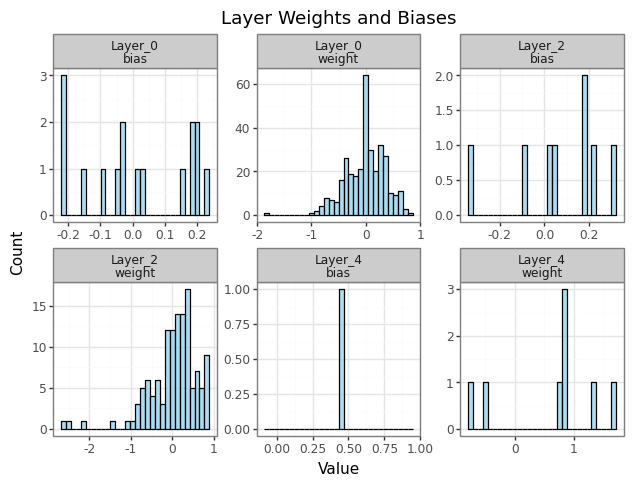

In [ ]:
mlp = mod.nodes_sites_layer.non_linear
print(mlp)

weights_list = [] 
for i, layer in enumerate(mlp): 
    if isinstance(layer, torch.nn.Linear): # Get weights and biases 
        w_np = layer.weight.detach().cpu().numpy().flatten() 
        b_np = layer.bias.detach().cpu().numpy().flatten()
        df_w = pd.DataFrame({
            'param_value': w_np,
            'param_type': 'weight',
            'layer': f'Layer_{i}'
        })
        df_b = pd.DataFrame({
            'param_value': b_np,
            'param_type': 'bias',
            'layer': f'Layer_{i}'
        })
        weights_list.append(df_w)
        weights_list.append(df_b)

weights_df = pd.concat(weights_list, ignore_index=True)

plot = (p9.ggplot(weights_df, p9.aes(x='param_value')) + 
        p9.geom_histogram(bins=30, fill="skyblue", color="black", alpha=0.7) + 
        p9.facet_wrap("~ layer + param_type", scales="free") + 
        p9.theme_bw() + 
        p9.labs(title="Layer Weights and Biases", x="Value", y="Count") )

plot.draw()

## Visualize

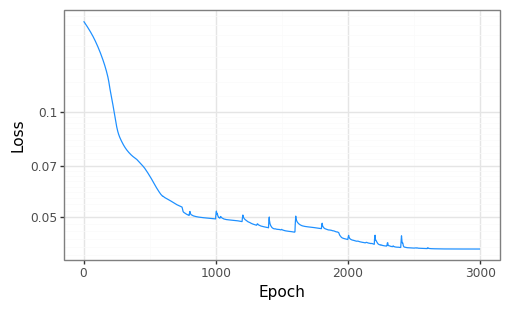

In [ ]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A.draw()

As well as how the learning rate was adjusted across training:

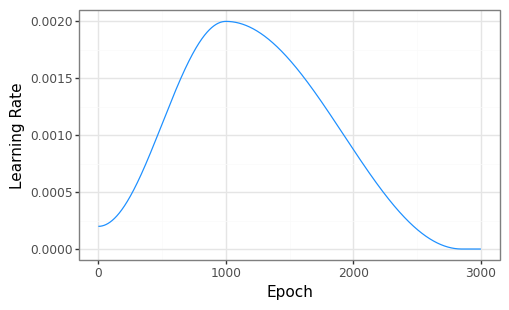

In [ ]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

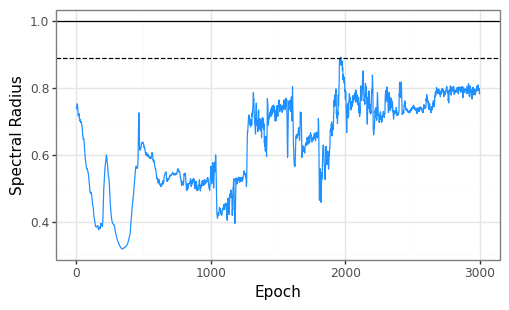

In [ ]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Plot how the time mapping is changing across epochs

In [ ]:
'''# Prepare the data for plotting
epochs = np.array(range(len(stats['mapping'])))
mapping_data = []

last_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping

for epoch, mapping in enumerate(stats['mapping']):
    for time_point, value in enumerate(mapping):
        time_point_name = last_iteration_mapping[time_point]
        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})

mapping_df = pd.DataFrame(mapping_data)
mapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)

# Real time points
real_time_points = [0, 1, 2, 3, 5, 10, 20, 50]
real_time_df = pd.DataFrame({'Real Time Points': real_time_points})

# Generate a color palette dictionary
color_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))

# Plot using plotnine
p = (
    p9.ggplot(mapping_df, p9.aes(x='Epoch', y='Value', color='Time Point')) +
    p9.geom_line(size=1) +
    p9.geom_hline(p9.aes(yintercept='Real Time Points'), data=real_time_df, color='black', linetype='dashed') +
    p9.scale_color_manual(values=color_palette) +
    p9.labs(x='Epoch', y='Time Mapping', color='Time Point') +
    p9.theme_classic()
)

p.draw()'''

"# Prepare the data for plotting\nepochs = np.array(range(len(stats['mapping'])))\nmapping_data = []\n\nlast_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping\n\nfor epoch, mapping in enumerate(stats['mapping']):\n    for time_point, value in enumerate(mapping):\n        time_point_name = last_iteration_mapping[time_point]\n        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})\n\nmapping_df = pd.DataFrame(mapping_data)\nmapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)\n\n# Real time points\nreal_time_points = [0, 1, 2, 3, 5, 10, 20, 50]\nreal_time_df = pd.DataFrame({'Real Time Points': real_time_points})\n\n# Generate a color palette dictionary\ncolor_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))\n\n# Plot using plotnin

### Model Benchmarking

Evaluate model. Plot correlation for each site after subtracting the time point zero from the site trajectory for each drug-cell line combination. Plot correlations across sites and across samples. Plot example site trajectory across cell lines and drugs.

torch.Size([72, 20377]) torch.Size([72, 20377])


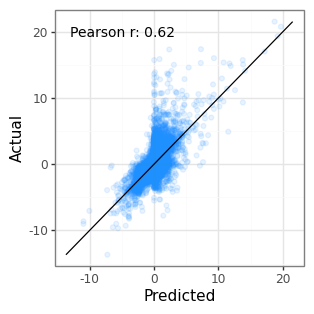

In [ ]:
def subsample_Y(Y, floor_idx, ceil_idx, weight):
    """
    Subsample Y using the provided indices and weights.

    Parameters
    ----------
    Y : torch.Tensor
        The tensor to be subsampled.
    floor_idx : torch.Tensor
        The floor indices for subsampling.
    ceil_idx : torch.Tensor
        The ceil indices for subsampling.
    weight : torch.Tensor
        The interpolation weights.

    Returns
    -------
    Y_subsampled : torch.Tensor
        The subsampled tensor.
    """
    Y = Y.to('cpu')
    
    # Reduce dimensions of indices
    floor_idx_reduced = floor_idx[0, :, 0]
    ceil_idx_reduced = ceil_idx[0, :, 0]
    
    # Gather the corresponding hidden state outputs
    Y_floor = Y[:, floor_idx_reduced, :]  # (batch, K, feat)
    Y_ceil = Y[:, ceil_idx_reduced, :]  # (batch, K, feat)
    
    # Perform linear interpolation
    Y_subsampled = (1 - weight) * Y_floor + weight * Y_ceil
    
    return Y_subsampled


y_index = mod.y_out.index.tolist()
y_actual = y_train

Y_hat_train, Y_full_train, Y_fullFull_train, Y_fullprotein = mod(X_train, X_cell_train, missing_node_indexes)

unique_time_points = [0, 2, 4, 8, 12] #[0, 2, 5, 10, 30, 60]  [0, 2, 5, 10, 20, 30, 60, 100]
Y_subsampled = Y_fullFull_train[:, unique_time_points, :]
#Y_subsampled = subsample_Y(Y_fullFull_train, floor_idx, ceil_idx, weight)
#Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_mean = torch.mean(Y_subsampled, dim=1, keepdim=True)
Y_subsampled = Y_subsampled - Y_mean
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(5, len(X_train_index), mod.y_out.shape[1])
#y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual_mean = torch.mean(y_actual, dim=0, keepdim=True)
y_actual = y_actual - y_actual_mean
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

In [ ]:
'''y_index = mod.y_out.index.tolist()
y_actual = y_test

Y_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod(X_test, X_cell_test, missing_node_indexes)

unique_time_points = [0, 2, 6, 24, 144]  #[0, 2, 4, 8, 12]
Y_subsampled = Y_fullFull_test[:, unique_time_points, :]
#Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(5, len(X_test), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()'''

"y_index = mod.y_out.index.tolist()\ny_actual = y_test\n\nY_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod(X_test, X_cell_test, missing_node_indexes)\n\nunique_time_points = [0, 2, 6, 24, 144]  #[0, 2, 4, 8, 12]\nY_subsampled = Y_fullFull_test[:, unique_time_points, :]\n#Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)\nY_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data\nY_subsampled = Y_subsampled.permute(1, 0, 2)\nY_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)\n\ny_actual = y_actual.reshape(5, len(X_test), mod.y_out.shape[1])\ny_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data\ny_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)\nprint(Y_subsampled.shape, y_actual.shape)\n\ny_pred_np = Y_subsampled.detach().flatten().cpu().numpy()\ny_actual_np = y_actual.detach().flatten().cpu().numpy()\n\n# Mask NaNs\nmask = ~np.isna

In [ ]:
'''filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]
site_names = mod.y_out.columns.tolist()

meta = []
for i, index_str in enumerate(filtered_y_index):
    parts = index_str.split('_')
    
    drug, cell_line, time = parts[0], parts[1], float(parts[2])
    meta.append({'row': i, 'drug': drug, 'cell_line': cell_line, 'time': time})
meta_df = pd.DataFrame(meta)

y_pred_np = Y_subsampled.detach().cpu().numpy()
y_actual_np = y_actual.detach().cpu().numpy()

corr_list = []
for (drug, cell_line), group in meta_df.groupby(['drug', 'cell_line']):
    group = group.sort_values('time')
    rows = group['row'].tolist()  # indices corresponding to this condition's time points
    for site in range(y_pred_np.shape[1]):  # for each site (gene)
        ts_pred = y_pred_np[rows, site]
        ts_actual = y_actual_np[rows, site]
        # Mask NaNs
        mask = ~np.isnan(ts_pred) & ~np.isnan(ts_actual)
        ts_pred = ts_pred[mask]
        ts_actual = ts_actual[mask]
        
        if len(ts_pred) > 1:
            r, _ = pearsonr(ts_pred, ts_actual)
            corr_list.append({'drug': drug, 'cell_line': cell_line, 'site': site_names[site], 'correlation': r})
corr_df = pd.DataFrame(corr_list)

p_corr = (p9.ggplot(corr_df, p9.aes(x='drug', y='correlation', color='cell_line'))
           + p9.geom_boxplot()
           + p9.geom_jitter(position=p9.position_jitter(width=0.1, height=0), size=1, alpha=0.1)
           + p9.facet_wrap("~ cell_line", ncol=2)
           + p9.scale_y_continuous(limits=(-1, 1))
           + p9.labs(x="Drug", y="Pearson Correlation")
           + p9.theme_bw(base_size=14)
           + p9.theme(figure_size=(10,8), legend_position='none'))
p_corr.draw()'''

'filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]\nsite_names = mod.y_out.columns.tolist()\n\nmeta = []\nfor i, index_str in enumerate(filtered_y_index):\n    parts = index_str.split(\'_\')\n    \n    drug, cell_line, time = parts[0], parts[1], float(parts[2])\n    meta.append({\'row\': i, \'drug\': drug, \'cell_line\': cell_line, \'time\': time})\nmeta_df = pd.DataFrame(meta)\n\ny_pred_np = Y_subsampled.detach().cpu().numpy()\ny_actual_np = y_actual.detach().cpu().numpy()\n\ncorr_list = []\nfor (drug, cell_line), group in meta_df.groupby([\'drug\', \'cell_line\']):\n    group = group.sort_values(\'time\')\n    rows = group[\'row\'].tolist()  # indices corresponding to this condition\'s time points\n    for site in range(y_pred_np.shape[1]):  # for each site (gene)\n        ts_pred = y_pred_np[rows, site]\n        ts_actual = y_actual_np[rows, site]\n        # Mask NaNs\n        mask = ~np.isnan(ts_pred) & ~np.isnan(ts_actual)\n        ts_pred = 

In [ ]:
'''meta_df['sample'] = meta_df['drug'] + "_" + meta_df['cell_line']

# Compute the correlation for each sample (drug–cell_line combination)
corr_list = []
for sample, group in meta_df.groupby('sample'):
    # Get constant sample properties
    drug = group['drug'].iloc[0]
    cell_line = group['cell_line'].iloc[0]
    
    # Get the rows corresponding to all time points for this sample.
    rows = group['row'].tolist()
    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)
    sample_ts_actual = y_actual_np[rows, :]
    ts_pred_flat = sample_ts_pred.flatten()
    ts_actual_flat = sample_ts_actual.flatten()
    
    # Remove NaN
    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))
    ts_pred_valid = ts_pred_flat[mask]
    ts_actual_valid = ts_actual_flat[mask]
    
    if len(ts_pred_valid) > 1:
        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)
        corr_list.append({
            'sample': sample,
            'drug': drug,
            'cell_line': cell_line,
            'correlation': r
        })

corr_df = pd.DataFrame(corr_list)
corr_df['x'] = 'All'

plot_corr = (
    p9.ggplot(corr_df, p9.aes(x='"All"', y='correlation'))
    + p9.geom_boxplot(alpha=0.3, width=0.2, outlier_alpha=0)
    + p9.geom_jitter(
          mapping=p9.aes(color='drug', shape='cell_line'),
          position=p9.position_jitter(width=0.1, height=0),
          size=3, alpha=0.8
      )
    + p9.scale_y_continuous(limits=(-1, 1))
    + p9.labs(x="", y="Pearson Correlation")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(10,8), legend_position='right')
)
plot_corr.draw()'''

'meta_df[\'sample\'] = meta_df[\'drug\'] + "_" + meta_df[\'cell_line\']\n\n# Compute the correlation for each sample (drug–cell_line combination)\ncorr_list = []\nfor sample, group in meta_df.groupby(\'sample\'):\n    # Get constant sample properties\n    drug = group[\'drug\'].iloc[0]\n    cell_line = group[\'cell_line\'].iloc[0]\n    \n    # Get the rows corresponding to all time points for this sample.\n    rows = group[\'row\'].tolist()\n    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)\n    sample_ts_actual = y_actual_np[rows, :]\n    ts_pred_flat = sample_ts_pred.flatten()\n    ts_actual_flat = sample_ts_actual.flatten()\n    \n    # Remove NaN\n    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))\n    ts_pred_valid = ts_pred_flat[mask]\n    ts_actual_valid = ts_actual_flat[mask]\n    \n    if len(ts_pred_valid) > 1:\n        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)\n        corr_list.append({\n            \'sample\': sample,\n     

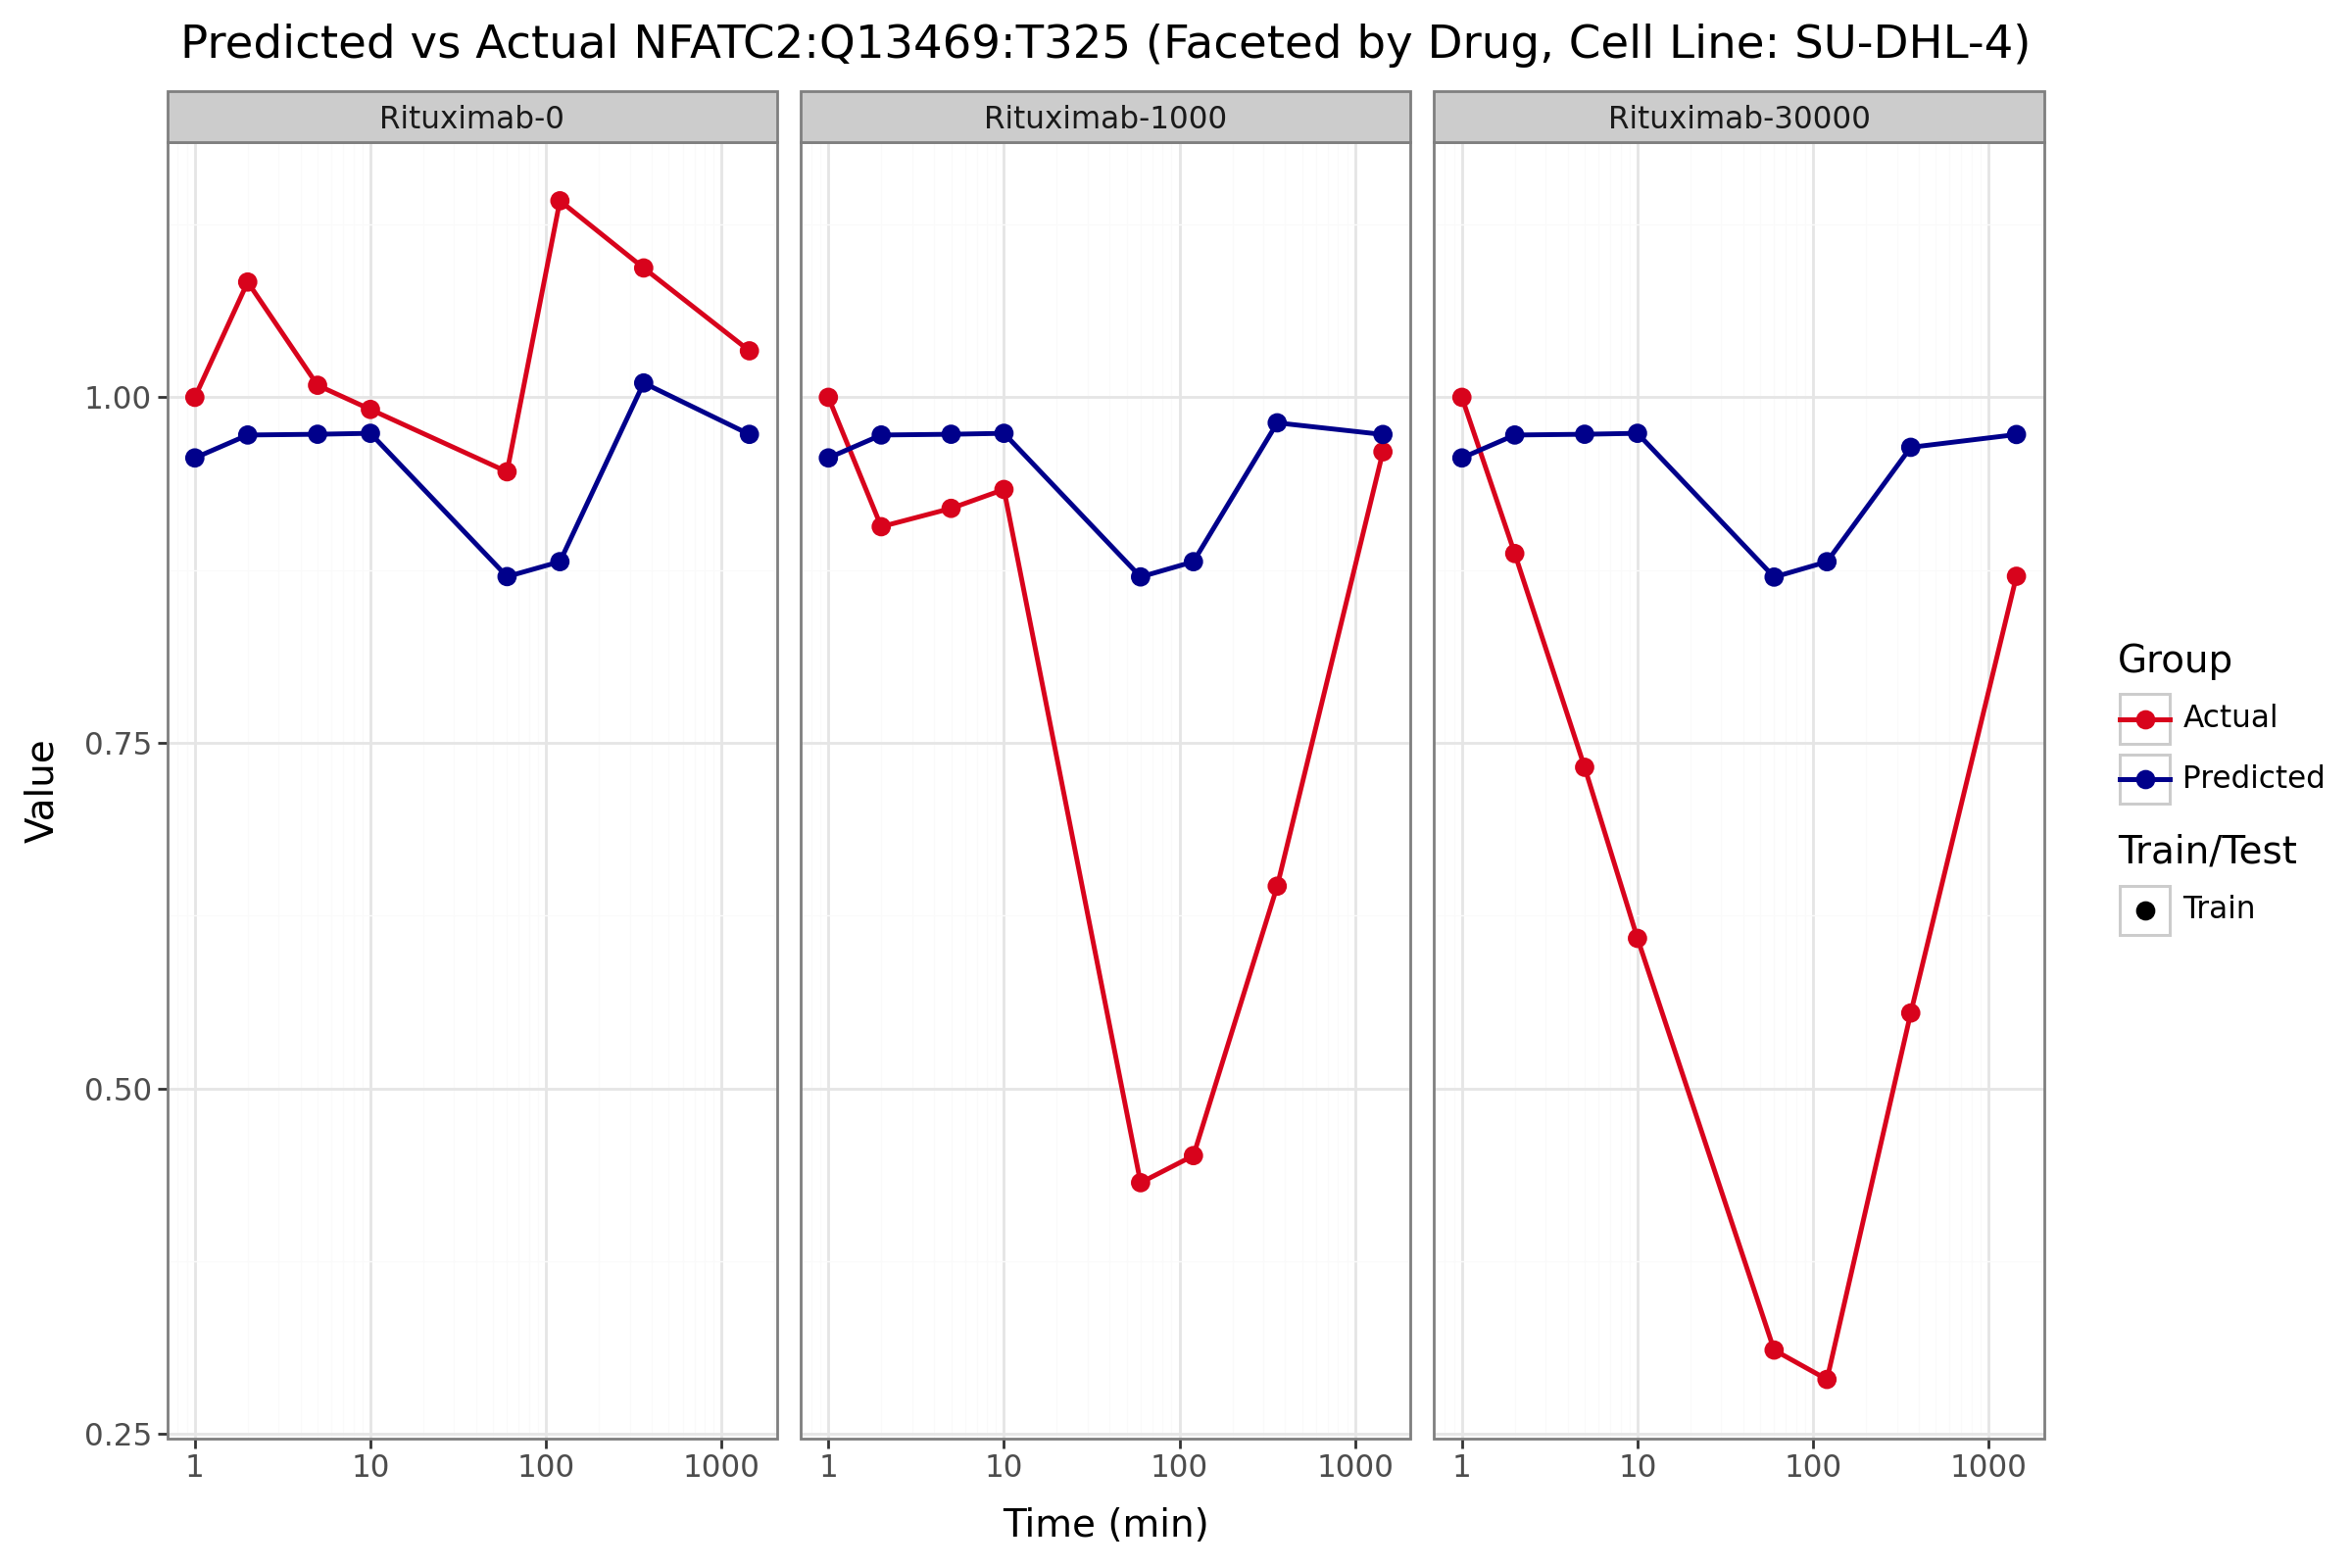

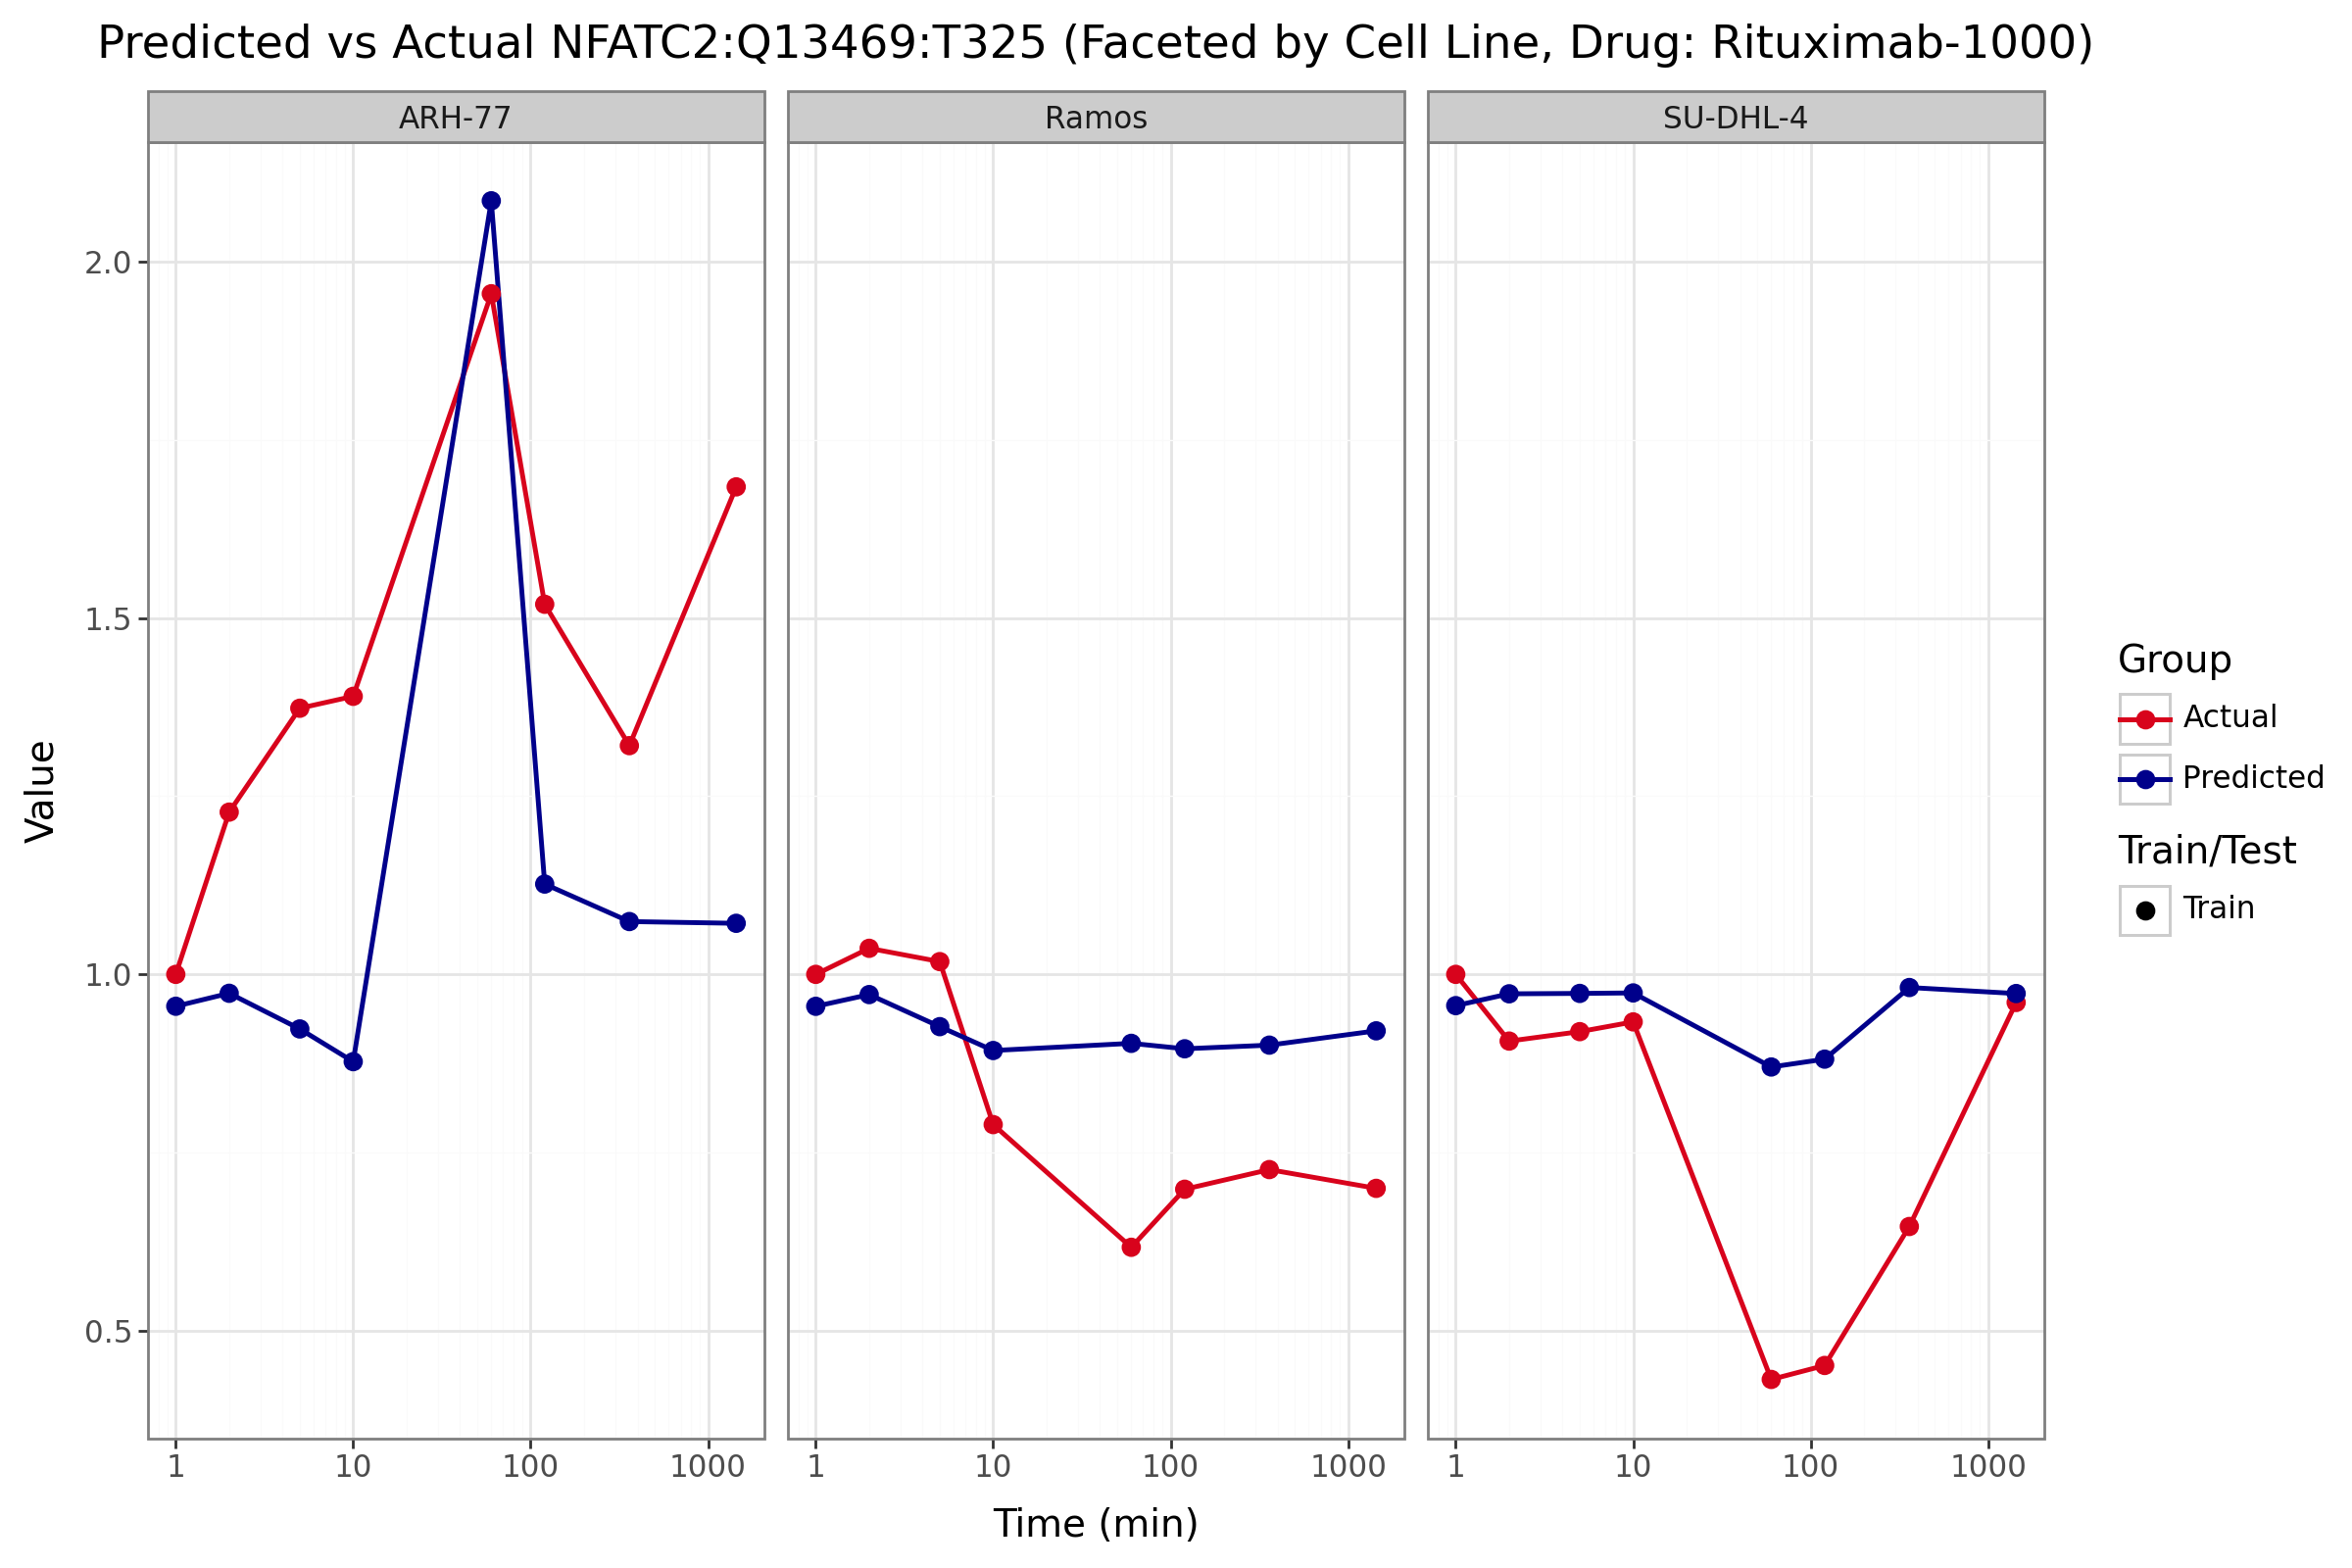

In [ ]:
drug_input = "EGF"
cl_input = "R1"
# DECRYPT: MAPK1:P28482:Y187, NFATC2:Q13469:T325
phosphosite_input = "1433T:P27348:S232s"  # MP2K2:P36507:S226s, BRAF:P15056:T753t, BRAF:P15056:S365s, MK01:P28482:T185t, MAPK2:P49137:T334t, SHC1:P29353:S139s, SHC1:P29353:S41s, SHC1:P29353:S453s, SHC1:P29353:Y349y, SHC1:P29353:Y350y, SHC1:P29353:Y427y, PTN11:Q06124:S142s, PTN11:Q06124:S562s, PTN11:Q06124:Y546y, PTN11:Q06124:Y62y, GAB1:Q13480:S209s, GAB1:Q13480:S266s, GAB1:Q13480:S274s, GAB1:Q13480:S355s, GAB1:Q13480:S401s, GAB1:Q13480:S419s, GAB1:Q13480:S500s, GAB1:Q13480:S551s, GAB1:Q13480:S634s, GAB1:Q13480:S650s, GAB1:Q13480:S651s, GAB1:Q13480:T199t, GAB1:Q13480:T211t, GAB1:Q13480:T365t, GAB1:Q13480:T377t, GAB1:Q13480:T390t, GAB1:Q13480:T503t, GAB1:Q13480:T638t, GAB1:Q13480:Y259y, GAB1:Q13480:Y285y, GAB1:Q13480:Y406y, GAB1:Q13480:Y447y, GAB1:Q13480:Y627y, GAB1:Q13480:Y659y
x_values = [0, 2, 4, 8, 12]  # 360, 1440
Y_plot = Y_fullFull[:, [0, 2, 4, 8, 12], :]
y_out = mod.df_to_tensor(mod.y_out)
#Y_plot = subsample_Y(Y_fullFull, floor_idx, ceil_idx, weight)
Y_plot = Y_plot.permute(1, 0, 2)
Y_plot = torch.flatten(Y_plot, start_dim=0, end_dim=1)

# Prepare the Y_actual
y_actual = y_data.reset_index().rename(columns={"index": "Drug_CL_Time"})
y_actual[['Drug', 'CL', 'Time']] = y_actual['Drug_CL_Time'].str.split('_', expand=True)
y_actual['Time'] = y_actual['Time'].astype(int)

df_cell = y_actual[y_actual['CL'] == cl_input].copy()
df_drug = y_actual[y_actual['Drug'] == drug_input].copy()

df_cell['Group'] = df_cell['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug['Group'] = df_drug['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})

# Sort the DataFrames by time for clarity.
df_cell = df_cell.sort_values(by=['Drug', 'CL', 'Time'])
df_drug = df_drug.sort_values(by=['Drug', 'CL', 'Time'])

cell_conditions = df_cell['Drug_CL_Time'].tolist()
drug_conditions = df_drug['Drug_CL_Time'].tolist()
cell_indices = [y_data.index.get_loc(cond) for cond in cell_conditions]
drug_indices = [y_data.index.get_loc(cond) for cond in drug_conditions]

phosphosite_idx = y_data.columns.get_loc(phosphosite_input)

# For the cell subset:
Y_cell_site = Y_plot[cell_indices, phosphosite_idx]
Drug, CL, Time = zip(*[cond.split('_') for cond in cell_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_cell_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_cell_site.detach().cpu().numpy(),
    'Drug': Drug
})

# For the drug subset:
Y_drug_site = Y_plot[drug_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in drug_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_drug_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_drug_site.detach().cpu().numpy(),
    'CL': CL
})

# Create the actual data
df_cell = df_cell[df_cell['Drug_CL_Time'].isin(cell_conditions)]
df_cell["Train/Test"] = df_cell["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_cell = df_cell[['Time', phosphosite_input, 'Drug', "Train/Test"]]
df_cell = df_cell.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_cell["Group"] = "Actual"

df_drug = df_drug[df_drug['Drug_CL_Time'].isin(drug_conditions)]
df_drug["Train/Test"] = df_drug["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug = df_drug[['Time', phosphosite_input, 'CL', "Train/Test"]]
df_drug = df_drug.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_drug["Group"] = "Actual"

df_cell_pred['Train/Test'] = df_cell['Train/Test'].reset_index(drop=True)
df_cell_pred['Group'] = "Predicted"
df_drug_pred['Train/Test'] = df_drug['Train/Test'].reset_index(drop=True)
df_drug_pred['Group'] = "Predicted"

df_cell_plot = pd.concat([df_cell, df_cell_pred], axis=0)
df_drug_plot = pd.concat([df_drug, df_drug_pred], axis=0)

# Plot A: Facet by Drug (for the specified cell line)
plot_A = (
    p9.ggplot(df_cell_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ Drug')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.scale_x_log10()
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Drug, Cell Line: {cl_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_A.show()

# Plot B: Facet by Cell Line (for the specified drug)
plot_B = (
    p9.ggplot(df_drug_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ CL')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.scale_x_log10()
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Cell Line, Drug: {drug_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_B.show()